# Deep Learning Collaborative Filtering for Food Recipe Suggestions
We demonstrate Collaborative filtering utilising [Food.com Recipes and Interactions datasets](https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions)  to recommend recipes to users in this notebook. The dataset contains the ratings provided to a set of food recipes by a group of users. Our objective is to be able to anticipate cooking times for recipes that a user has not yet seen. The user will then be recommended the recipes with the highest anticipated ratings.

The model's steps are as follows:

An embedding matrix is used to map a user ID to a "user vector."
An embedding matrix is used to map a recipe ID to a "recipe vector."
Calculate the dot product of the user vector and the movie vector to get a match score between the user and the recipe (predicted rating).
Use gradient descent to train the word embedding.

# Table of Contents

<a id="toc"></a>
- [1. Set-up](#1)
    - [1.1 Import Libraries](#1.1)
- [2. Load Datasets](#2)
- [3. Getting the Data Ready](#3)
    - [3.1 Select features](#3.1)    
    - [3.2 Preprocessing](#3.2)
    - [3.3 Split Data](#3.3)
- [4. Building models](#4)
    - [4.1 Matrix factorization method](#4.1)
    - [4.2 Plot Model Results](#4.2)
    - [4.3 Plot Model Weights](#4.2)
- [5. Showing the user the top ten recipe recommendations](#5)
- [6. Save Weights](#6)


<a id="1"></a>
# <b>1 <span style='color:#F1A424'>|</span> Set-up</b>

In [100]:
import re, string, gc, os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import tensorflow as tf
import nltk.corpus
import matplotlib.pyplot as plt
import seaborn as sns

In [101]:
# pandas configuration 
pd.set_option('display.max_colwidth', 1000) # for automatic linebreaks and multi-line cells.
pd.set_option('display.max_columns', 1000) 
pd.set_option('display.width', 1000)
# English stop words
STOPWORDS = set(nltk.corpus.stopwords.words('english')) 
# ignore future warnings
import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)

<a id="2"></a>
# <b>2 <span style='color:#F1A424'>|</span> Load Datasets</b>

In [102]:
def get_data():
    df_recipes = pd.read_csv("../input/food-com-recipes-and-user-interactions//RAW_recipes.csv")
    df_interactions = pd.read_csv("../input/food-com-recipes-and-user-interactions/RAW_interactions.csv")
    return pd.concat([df_recipes, df_interactions], axis=1, join='inner')

df_recipes = get_data()

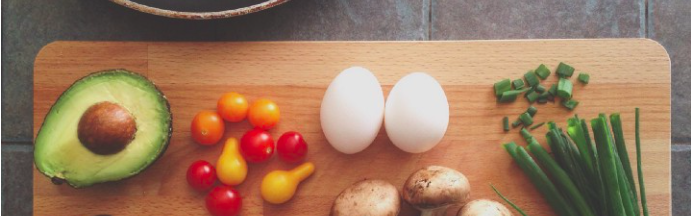

<a id="3"></a>
# <b>3 <span style='color:#F1A424'>|</span> Getting the Data Ready</b>

<a id="3.1"></a>
## <b>3.1 <span style='color:#F1A424'>Select features</span></b> 

In [103]:
df = df_recipes[['user_id', 'recipe_id', 'rating']]
df.head()

,user_id,recipe_id,rating
0,38094,40893,4
1,1293707,40893,5
2,8937,44394,4
3,126440,85009,5
4,57222,85009,5


<a id="3.2"></a>
## <b>3.2 <span style='color:#F1A424'>Preprocessing</span></b> 

In [104]:
df['rating'] = df['rating'].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating, max_rating = min(df["rating"]), max(df["rating"])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [105]:
num_users, num_recipes = len(df["user_id"].unique().tolist()), len(df["recipe_id"].unique().tolist())

In [106]:
print(f"Number of users: {num_users}, Number of Recipes: {num_recipes}, Min Rating: {min_rating}, Max Rating: {max_rating}")

Number of users: 70390, Number of Recipes: 46702, Min Rating: 0.0, Max Rating: 5.0


<a id="3.3"></a>
## <b>3.3 <span style='color:#F1A424'>Split Data</span></b> 

In [107]:
df[["recipe_id", "user_id"]]

,recipe_id,user_id
0,40893,38094
1,40893,1293707
2,44394,8937
3,85009,126440
4,85009,57222
...,...,...
231632,109385,1018804
231633,188451,75497
231634,109385,1248706
231635,109385,673339


In [108]:
df = df.sample(frac=1, random_state=42)
x = df[["recipe_id", "user_id"]].values

# Normalizing the targets between 0 and 1. Makes it easy to train.
#y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Assuming training on 90% of the data and validating on 100%
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)
x_train[0], y_train[0]

(array([  66121, 1942043]), 1.0)

<a id="4"></a>
# <b>4 <span style='color:#F1A424'>|</span> Building models</b>

<a id="4.1"></a>
## <b>4.1 <span style='color:#F1A424'>Matrix factorization method</span></b> 

* Users and recipes embedding layers with the same number of factors.
* user and recipes bias layers which can be considered as representation of the unique inherent characteristic of each user/recipe.

We will take the element-wise product of the two embeddings and add the bias terms. The rest is all about experimenting with layers and tuning hyper parameters.

Both users and recipes are embedded in 1000-dimensional vectors. A dot product is used to compute a similarity metric between user and recipe embeddings, and a per-recipe and per-user bias is added. A sigmoid is used to call the match score to the [0, 1] interval (since our ratings are normalized to this range).

In [109]:
EMBEDDING_SIZE = 1000

In [110]:
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_recipes, num_users, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_recipes = num_recipes
        self.num_users = num_users
        self.embedding_size = embedding_size
        # Layers
        self.recipes_embedding = tf.keras.layers.Embedding(
            num_recipes,
            embedding_size,
            embeddings_initializer = "he_normal",
            embeddings_regularizer = tf.keras.regularizers.l2(1e-6),
            name = "Recipe-Embedding"
        )
        self.recipes_bias = tf.keras.layers.Embedding(num_recipes, 1, name="Recipe-Embedding-bias")
        self.user_embedding = tf.keras.layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer = "he_normal",
            embeddings_regularizer = tf.keras.regularizers.l2(1e-6),
            name = "User-Embedding"
        )
        self.user_bias = tf.keras.layers.Embedding(num_users, 1, name="User-Embedding-bias")
        ## add matrix_product layers
        self.matrix_product = tf.keras.layers.Multiply(name = "multiply")
        self.drop = tf.keras.layers. Dropout(0.2, name = "Dropout")
        ## concat layers
        self.concat = tf.keras.layers.Concatenate(name = "Concat")
        self.flatten = tf.keras.layers.Flatten(name = "Flatten")
        ## add dense layers
        self.dense_1 = tf.keras.layers.Dense(50, activation="relu", name="Dense1")
        self.dense_2 = tf.keras.layers.Dense(20, activation="relu", name="Dense2")
        self.result = tf.keras.layers.Dense(1, activation='relu', name='Activation')

    def call(self, inputs):
        recipe_vector = self.recipes_embedding(inputs[:, 0])
        recipe_bias = self.recipes_bias(inputs[:, 0])
        user_vector = self.user_embedding(inputs[:, 1])
        user_bias = self.user_bias(inputs[:, 1])
        ## add matrix_product layers
        max_prod = self.matrix_product([recipe_vector, user_vector])
        max_prod = self.drop(max_prod)
        ## add dense layers
        input_terms = self.concat([max_prod, recipe_bias, user_bias])
        input_terms = self.flatten(input_terms)
        ## add dense layers
        dense_1 = self.dense_1(input_terms)
        dense_1 = self.drop(dense_1)
        dense_2 = self.dense_2(dense_1)
        dense_2 = self.drop(dense_2)
        out = self.result(dense_2)
        return out

model = RecommenderNet(num_recipes, num_users, EMBEDDING_SIZE)
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(), #['mse'], 
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics = ['mean_absolute_error']
)

Training the Model on the Split Data

In [111]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 64,
    epochs = 1,
    #verbose=1,
    validation_data = (x_val, y_val)
)

Epoch 1/100
815/815 [==============================] - 48s 57ms/step - loss: 0.7212 - mean_absolute_error: 0.3518 - val_loss: 0.4075 - val_mean_absolute_error: 0.2363
Epoch 2/100
815/815 [==============================] - 47s 58ms/step - loss: 0.5163 - mean_absolute_error: 0.2690 - val_loss: 0.4250 - val_mean_absolute_error: 0.2358
Epoch 3/100
815/815 [==============================] - 47s 58ms/step - loss: 0.4957 - mean_absolute_error: 0.2693 - val_loss: 0.4292 - val_mean_absolute_error: 0.2454
Epoch 4/100
815/815 [==============================] - 47s 58ms/step - loss: 0.5174 - mean_absolute_error: 0.2838 - val_loss: 0.5577 - val_mean_absolute_error: 0.3552
Epoch 5/100
815/815 [==============================] - 47s 58ms/step - loss: 0.4871 - mean_absolute_error: 0.2733 - val_loss: 0.4098 - val_mean_absolute_error: 0.2325
Epoch 6/100
815/815 [==============================] - 47s 58ms/step - loss: 0.4687 - mean_absolute_error: 0.2611 - val_loss: 0.4151 - val_mean_absolute_error: 0.234

<a id="4.2"></a>
## <b>4.2 <span style='color:#F1A424'>Plot Model Results</span></b> 

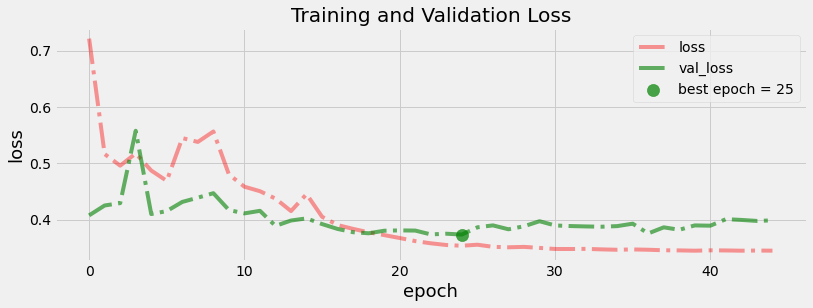

In [112]:
tloss = history.history['loss']
vloss = history.history['val_loss']
# the epoch with the lowest validation loss
index_loss = np.argmin(vloss)
acc_highest = vloss[index_loss]

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 4))
plt.plot(tloss, label='loss', c='r', alpha=0.4, ls = '-.')
plt.plot(vloss, label='val_loss', c='g', alpha=0.6, ls = '-.')
plt.scatter(
    index_loss, 
    acc_highest, 
    s = 150, 
    c = 'g',
    alpha = 0.7,
    label = f'best epoch = {str(index_loss + 1)}'
)

plt.title('Training and Validation Loss')
plt.ylabel('loss', fontsize=18)
plt.xlabel('epoch', fontsize=18)
plt.legend();

<a id="4.3"></a>
## <b>4.3 <span style='color:#F1A424'>Plot Model Weights</span></b> 

Embeddings can be used to visualize concepts such as the relation of different books in our case. To visualize these concepts, we need to reduce dimensionality further using dimensionality reduction techniques like principal component analysis (PSA) or t-distributed stochastic neighbor embedding (TSNE).

Starting with 10000 dimensions (one for each book), we map them to 5 dimensions using embedding and then further map them to 2 dimensions using PCA or TSNE.

Extract the book embedding weights

In [113]:
# Extract embeddings
recipe_em = model.get_layer('Recipe-Embedding')
recipe_em_weights = recipe_em.get_weights()[0]

Using PCA to transform embeddings to 2 dimensions and then scatter the results

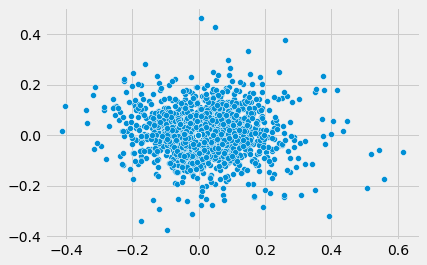

In [114]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(recipe_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1]);

The same can be done using TSNE:

In [115]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
#tnse_results = tsne.fit_transform(recipe_em_weights)
#sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1]);

<a id="5"></a>
# <b>5 <span style='color:#F1A424'>|</span> Showing the user the top ten recipe recommendations.</b>

### Interpretation of embedding/bias values

Ideally, if we have trained the model enough to learn about the latent factors of the users/recipes, the values of the bias or embedding matrices should have a meaning about the underlying characteristics of what they represent. Although this model is preliminary, we will see how we could interpret these values with a good model.

In [116]:
# Number of users: 70390, Number of Recipes: 46702,

Create a dictionary with the recipe id and recipe name.

In [117]:
recipe_dict = df_recipes.set_index('recipe_id')['name'].to_dict()
len(recipe_dict)

46702

In [118]:
pca = PCA(n_components = 3) ## use 3 components
recipe_em_weights = np.transpose(recipe_em_weights) ## pass the transpose of the embedding matrix
recipe_pca = pca.fit(recipe_em_weights) ## fit

## display the resulting matrix dimensions
print(f"The resulting matrix dimensions: {recipe_pca.components_.shape}")

## display the variance explained by the 3 components
print(f"The variance explained by the 3 components: {recipe_pca.explained_variance_ratio_}")

The resulting matrix dimensions: (3, 46702)
The variance explained by the 3 components: [0.07287989 0.04137975 0.03749133]


     If the variance explained is very low, we might not be able to see a good interpretation.

Extract the first component/factor that explains the highest percentage of the variance. The array we get can be mapped to the books names as follows.

In [119]:
idx = np.argmax(recipe_pca.explained_variance_ratio_)

In [120]:
## extract first PCA
pca_components = recipe_pca.components_[idx]

## get the value (pca_components, recipe name)
recipe_comp = [(f, recipe_dict[i]) for f,i in zip(pca_components, list(recipe_dict.keys()))]

In [121]:
from operator import itemgetter

recommended_recipes = sorted(recipe_comp, key=itemgetter(0), reverse=True)[:10]
recommended_recipes = pd.DataFrame(recommended_recipes, columns=['pca_components', 'Recipe'])
print("----" * 8)
print("Top 10 Recipe recommendations")
print("----" * 8, '\n')
recommended_recipes

--------------------------------
Top 10 Recipe recommendations
-------------------------------- 



,pca_components,Recipe
0,0.121945,cream of sun dried tomato soup
1,0.110181,chicken in foil triangles aka twice baked chicken
2,0.107680,lion s head meatballs chinese comfort food
3,0.103189,mini quiches
4,0.100866,fluffernutter
5,0.088352,chicken noodle casserole
6,0.085948,corn ice cream
7,0.083204,old bay seasoning substitute
8,0.080641,negative cookies
9,0.079335,kumara burger sweet potato


<a id="6"></a>
# <b>6 <span style='color:#F1A424'>|</span> Save weights</b>

In [129]:
model_name = 'recipe_generation_rnn.h5'
model.save_weights(model_name)